In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Add
from keras.models import Model
from keras import backend as K
import numpy as np
from google.colab import files
import os, glob
import cv2
import matplotlib.pyplot as plt
import random
import copy

# Getting the data

upload the dataset

In [50]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving animeface-character-dataset.zip to animeface-character-dataset.zip
User uploaded file "animeface-character-dataset.zip" with length 592335393 bytes


move into directory

In [0]:
mkdir datalab
mv animeface-character-dataset.zip ../datalab/animeface-character-dataset.zip

unzipping

In [109]:
!7z x ../datalab/animeface-character-dataset.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../datalab/                     1 file, 592335393 bytes (565 MiB)

Extracting archive: ../datalab/animeface-character-dataset.zip
 27% 4096 Open              --
Path = ../datalab/animeface-character-dataset.zip
Type = zip
Physical Size = 592335393

  0%    
Would you like to replace the existing file:
  Path:     ./animeface-character-dataset/index.html
  Size:     534 bytes (1 KiB)
  Modified: 2010-02-14 17:54:44
with the file from archive:
  Path:     animeface-character-dataset/index.html
  Size:     534 bytes (1 KiB)
  Modified: 2010-02-14 17:54:44
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? A

  0% - animeface-character-dataset/index.html

split into test, validation and train data - getting data

In [0]:
x_train = []
x_val = []
x_test = []

directories = os.listdir('animeface-character-dataset/thumb/')
for directory in directories:
  dir_path = 'animeface-character-dataset/thumb/'+directory
  num_fil = 0
  num_train = 0
  num_val = 0
  num_test = 0
  if os.path.isdir(dir_path):
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        num_fil += 1
    num_train = int(round(num_fil*0.7))
    num_val = int(round((num_fil-num_train)*0.5))
    num_test = int(round(num_fil-num_train-num_val))
    i = 0
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        filepath = dir_path+"/"+filename
        if i<num_train:
          img = cv2.imread(filepath, 0)
          img = cv2.resize(img, (64,64))
          x_train.append(img)
        elif i<(num_train+num_val):
          img = cv2.imread(filepath, 0)
          img = cv2.resize(img, (64,64))
          x_val.append(img)
        elif i<(num_train+num_val+num_train):
          img = cv2.imread(filepath, 0)
          img = cv2.resize(img, (64,64))
          x_test.append(img)
        i += 1
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

example of data

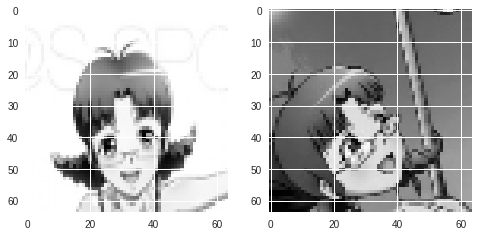

In [373]:
plt.subplot(1, 2, 1)
plt.imshow(x_train[1])
plt.subplot(1, 2, 2)
plt.imshow(x_val[1])
plt.show()

data normalization and reshaping

In [0]:
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_val = np.reshape(x_val, (len(x_val), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))

# Denoising

apply noise

In [0]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

example of noisy images

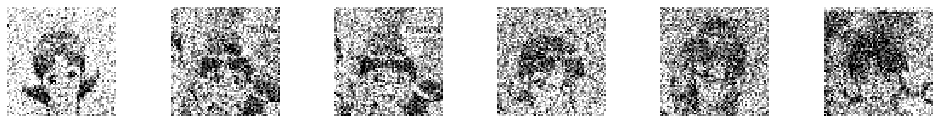

In [376]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

convolutional autoencoder model

In [0]:
input_img = Input(shape=(64, 64, 1))  # shape of the images that wil be on input

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

training of images

In [422]:
log = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_noisy, x_val))

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
10133/10133 [==============================] - 7s 673us/step - loss: 0.5254 - val_loss: 0.5184
Epoch 2/100
10133/10133 [==============================] - 7s 674us/step - loss: 0.5176 - val_loss: 0.5186
Epoch 3/100
10133/10133 [==============================] - 7s 675us/step - loss: 0.5165 - val_loss: 0.5173
Epoch 4/100
10133/10133 [==============================] - 7s 674us/step - loss: 0.5164 - val_loss: 0.5177
Epoch 5/100
10133/10133 [==============================] - 7s 673us/step - loss: 0.5159 - val_loss: 0.5168
Epoch 6/100
10133/10133 [==============================] - 7s 674us/step - loss: 0.5159 - val_loss: 0.5171
Epoch 7/100
10133/10133 [==============================] - 7s 672us/step - loss: 0.5158 - val_loss: 0.5166
Epoch 8/100
10133/10133 [==============================] - 7s 672us/step - loss: 0.5154 - val_loss: 0.5174
Epoch 9/100
10133/10133 [==============================] - 7s 672us/step - loss: 0.5154 - val_l

graph of losses

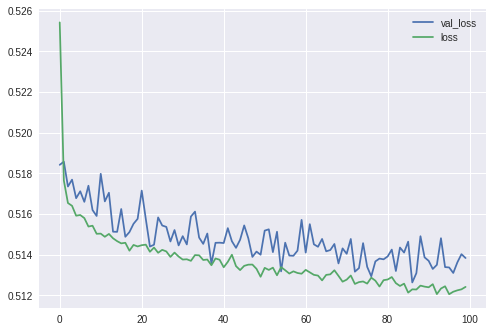

In [423]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

feeding test data into the decoder

In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

visualizing the noisy test images, reconstructed images and original images

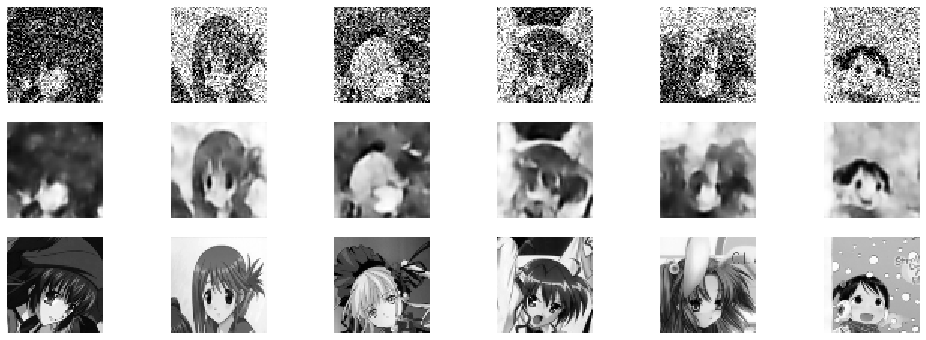

In [425]:
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display noisy
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(x_test[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Inpainting - stripes

creating images with stripes

In [0]:
stripes_no = 24
x_train_inpaint = copy.deepcopy(x_train)
x_val_inpaint = copy.deepcopy(x_val)
x_test_inpaint = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_train_inpaint[i])):
        if j in stripes:
            x_train_inpaint[i][j] = np.zeros((64,1))
            
for i in range(len(x_val_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_val_inpaint[i])):
        if j in stripes:
            x_val_inpaint[i][j] = np.zeros((64,1))

for i in range(len(x_test_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_test_inpaint[i])):
        if j in stripes:
            x_test_inpaint[i][j] = np.zeros((64,1))

example of images with stripes

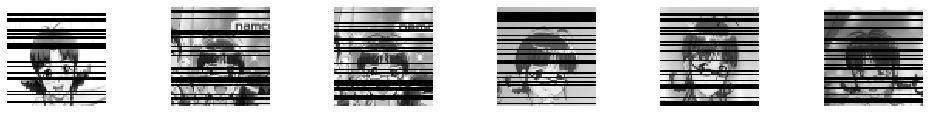

In [395]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

training on the same network model

In [416]:
log = autoencoder.fit(x_train_inpaint, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint, x_val))

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
10133/10133 [==============================] - 7s 658us/step - loss: 0.5517 - val_loss: 0.5361
Epoch 2/100
10133/10133 [==============================] - 7s 657us/step - loss: 0.5303 - val_loss: 0.5276
Epoch 3/100
10133/10133 [==============================] - 7s 659us/step - loss: 0.5250 - val_loss: 0.5246
Epoch 4/100
10133/10133 [==============================] - 7s 658us/step - loss: 0.5220 - val_loss: 0.5183
Epoch 5/100
10133/10133 [==============================] - 7s 655us/step - loss: 0.5193 - val_loss: 0.5209
Epoch 6/100
10133/10133 [==============================] - 7s 658us/step - loss: 0.5177 - val_loss: 0.5172
Epoch 7/100
10133/10133 [==============================] - 7s 656us/step - loss: 0.5164 - val_loss: 0.5166
Epoch 8/100
10133/10133 [==============================] - 7s 654us/step - loss: 0.5152 - val_loss: 0.5156
Epoch 9/100
10133/10133 [==============================] - 7s 655us/step - loss: 0.5147 - val_l

graph of losses

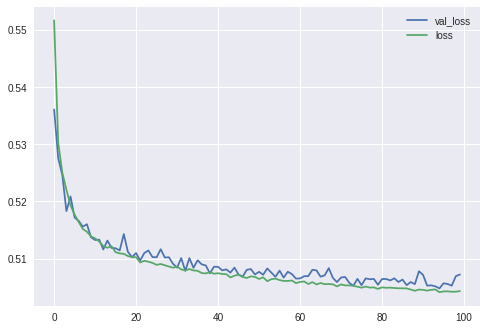

In [417]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

feeding test data into the decoder

In [0]:
decoded_imgs_inpaint = autoencoder.predict(x_test_inpaint)

visualization of the input test images with stripes, reconstructed images and original images

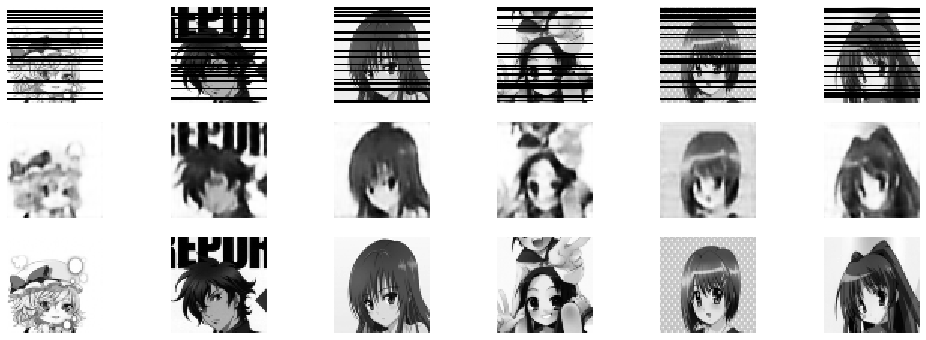

In [419]:
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display noisy
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_inpaint[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs_inpaint[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(x_test[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Inpainting - blocks

creating images with randomly placed gray blocks

In [0]:
block_size = 24
x_train_inpaint_block = copy.deepcopy(x_train)
x_val_inpaint_block = copy.deepcopy(x_val)
x_test_inpaint_block = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_train_inpaint_block[i][x+j][y+k] = 0.5 # gray color
            
for i in range(len(x_val_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_val_inpaint_block[i][x+j][y+k] = 0.5 

for i in range(len(x_test_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_test_inpaint_block[i][x+j][y+k] = 0.5

example of images with randomly placed gray blocks

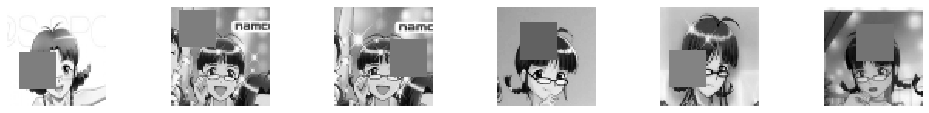

In [404]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint_block[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

fitting data into the autoencoder

In [428]:
log = autoencoder.fit(x_train_inpaint_block, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint_block, x_val),
               verbose=2)

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
 - 8s - loss: 0.6445 - val_loss: 0.8457
Epoch 2/100
 - 7s - loss: 0.6072 - val_loss: 0.5646
Epoch 3/100
 - 7s - loss: 0.5707 - val_loss: 0.5575
Epoch 4/100
 - 7s - loss: 0.5596 - val_loss: 0.5567
Epoch 5/100
 - 7s - loss: 0.5551 - val_loss: 0.5556
Epoch 6/100
 - 7s - loss: 0.5510 - val_loss: 0.5531
Epoch 7/100
 - 7s - loss: 0.5491 - val_loss: 0.5472
Epoch 8/100
 - 7s - loss: 0.5467 - val_loss: 0.5470
Epoch 9/100
 - 7s - loss: 0.5450 - val_loss: 0.5472
Epoch 10/100
 - 7s - loss: 0.5438 - val_loss: 0.5459
Epoch 11/100
 - 7s - loss: 0.5425 - val_loss: 0.5404
Epoch 12/100
 - 7s - loss: 0.5408 - val_loss: 0.5375
Epoch 13/100
 - 7s - loss: 0.5397 - val_loss: 0.5474
Epoch 14/100
 - 7s - loss: 0.5393 - val_loss: 0.5366
Epoch 15/100
 - 7s - loss: 0.5378 - val_loss: 0.5394
Epoch 16/100
 - 7s - loss: 0.5365 - val_loss: 0.5366
Epoch 17/100
 - 7s - loss: 0.5360 - val_loss: 0.5348
Epoch 18/100
 - 7s - loss: 0.5343 - val_loss: 0.5346
Epoch 

graph of losses

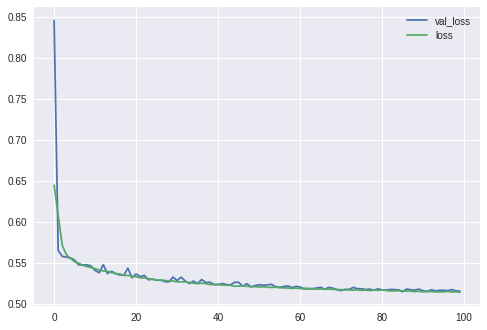

In [429]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

predicting the test data with blocks

In [0]:
decoded_imgs_inpaint_block = autoencoder.predict(x_test_inpaint_block)

visualization of the input test images with gray blocks, reconstructed images and original images

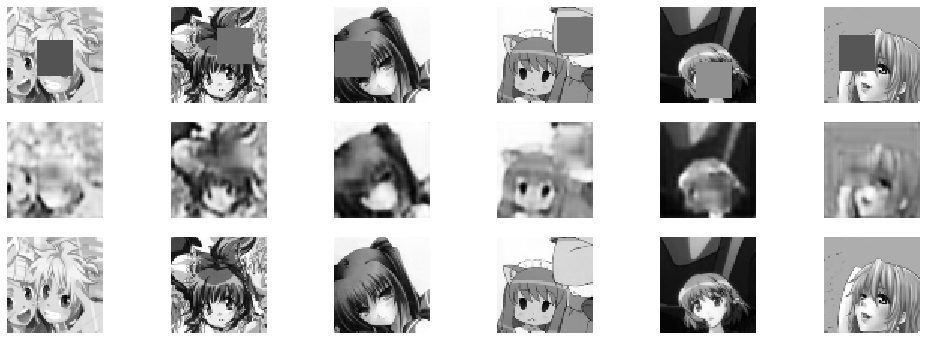

In [431]:
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display noisy
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_inpaint_block[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs_inpaint_block[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(x_test[r].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()